# Homework 2: RAG Pattern - Question Answering using Gemini, LangChain, and Chroma

### Overview

To begin is some starter code to get you started in getting the dataset with which the homework questions are based on. This is an adaptation of the Gemini_LangChain_QA_Chroma_WebLoad.ipynb that was shown in class during week 5.

### Setup

First, you must install the packages and set the necessary environment variables.

### Installation

Install LangChain's Python library, `langchain`.

In [ ]:
!pip install --quiet langchain
!pip install -U --quiet langchain-community

Install LangChain's integration package for Gemini, `langchain-google-genai`.

In [ ]:
!pip install --quiet langchain-google-genai

Install Chroma's Python client SDK, `chromadb`.

In [4]:
!pip install --quiet chromadb

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.72.0rc1 requires protobuf<7.0dev,>=6.30.0, but you have protobuf 5.29.4 which is incompatible.


In [5]:
!pip install --quiet beautifulsoup4

### Grab an API Key

To use Gemini you need an *API key*. You can create an API key with one click in [Google AI Studio](https://makersuite.google.com/).
After creating the API key, you can either set an environment variable named `GOOGLE_API_KEY` to your API Key.

In the cell below you can paste your Gemini API key when prompted to do so and press enter.

In [6]:
# Run this cell and paste the API key in the prompt
import os
import getpass

os.environ['GOOGLE_API_KEY'] = getpass.getpass('Gemini API Key:')

### Basic steps
LLMs are trained offline on a large corpus of public data. Hence they cannot answer questions based on custom or private data accurately without additional context.

If you want to make use of LLMs to answer questions based on private data, you have to provide the relevant documents as context alongside your prompt. This approach is called Retrieval Augmented Generation (RAG).


### Import the required libraries

In [7]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.


In [8]:
from langchain import PromptTemplate
from langchain import hub
from langchain.docstore.document import Document
from langchain.document_loaders import WebBaseLoader
from langchain.schema import StrOutputParser
from langchain.schema.prompt_template import format_document
from langchain.schema.runnable import RunnablePassthrough
from langchain.vectorstores import Chroma
from langchain.document_loaders import DataFrameLoader
import requests
from bs4 import BeautifulSoup
import pandas as pd


USER_AGENT environment variable not set, consider setting it to identify your requests.




```
# This is formatted as code
```

### Acquire the data

The following is the code to get the 28 (so far) proclamations that President Donald Trump has made during his second term in office. These are all available at https://www.whitehouse.gov/presidential-actions/proclamations/ and will be used as the corpus of documents from which your RAG solution should answer questions.

In [9]:
site = "https://www.whitehouse.gov/presidential-actions/proclamations/page/"

In [10]:
#iterates through the 3 pages of proclamations and grabs the title and web link
pgs = ["1/","2/","3/"]
all_procs=[]

for i in pgs:
  html_stuff = requests.get(site + i).text 
  procs = BeautifulSoup(html_stuff) #用 BeautifulSoup 解析 HTML
  procs = procs.find_all('h2',{'class':'wp-block-post-title'})
  all_procs.extend(procs)

In [11]:
link = all_procs[1].find('a')['href']
requests.get(link).text



'<!DOCTYPE html>\n<html lang="en-US">\n<head>\n\t<meta charset="UTF-8" />\n\t<meta name="viewport" content="width=device-width, initial-scale=1" />\n<meta name=\'robots\' content=\'index, follow, max-image-preview:large, max-snippet:-1, max-video-preview:-1\' />\n\t<style>img:is([sizes="auto" i], [sizes^="auto," i]) { contain-intrinsic-size: 3000px 1500px }</style>\n\t\n\t<meta name="description" content="By the President of the United States of America&nbsp;A Proclamation&nbsp;&nbsp; Military spouses are the heart and soul of our Armed Forces.\xa0 Their" />\n\t<link rel="canonical" href="https://www.whitehouse.gov/presidential-actions/2025/05/military-spouse-day-2025/" />\n\t<meta property="og:locale" content="en_US" />\n\t<meta property="og:type" content="article" />\n\t<meta property="og:title" content="Military Spouse Day, 2025" />\n\t<meta property="og:description" content="By the President of the United States of America&nbsp;A Proclamation&nbsp;&nbsp; Military spouses are the he

In [12]:
#example of first proclomation
all_procs[1]

<h2 class="wp-block-post-title"><a href="https://www.whitehouse.gov/presidential-actions/2025/05/military-spouse-day-2025/" target="_self">Military Spouse Day, 2025</a></h2>

$<h2>$二级小标题

In [13]:
import requests
from bs4 import BeautifulSoup

all_results = []

for proc in all_procs:
    title = proc.text.strip()                     # 获取标题
    link = proc.find('a')['href']                 # 获取链接

    # 请求每一篇公告的详细页面
    detail_html = requests.get(link).text
    detail_soup = BeautifulSoup(detail_html, 'html.parser')

    # 提取正文内容：看白宫网站常用的正文 class 是 'page-content__content'
    content_div = detail_soup.find('div', class_='entry-content wp-block-post-content has-global-padding is-layout-constrained wp-block-post-content-is-layout-constrained')
    paragraphs = content_div.find_all('p') if content_div else []
    text = '\n\n'.join([p.get_text(strip=True) for p in paragraphs])

    all_results.append({
        'Title': title,
        'URL': link,
        'Text': text
    })

result = pd.DataFrame(all_results)


### Homework Part 1 Acquire Documents

The preceding code pulls a list of all the Presidential Proclamations, their weblinks and Titles. The first part of the homework is to iterate through list `all_procs` to get the associated text for each one of the Proclamations and then make a dataframe.

In [14]:
# HOMEWORK PART 1
#iterate through all the proclamations to get the actual page text
#in addition to title and weblink

import requests
from bs4 import BeautifulSoup

all_results = []

for proc in all_procs:
    title = proc.text.strip()                     
    link = proc.find('a')['href']                 # THis is where we trace a to find the link 

    # Request for every proclaimation
    detail_html = requests.get(link).text #getting the html of the notice board
    detail_soup = BeautifulSoup(detail_html, 'html.parser')

    # 提取正文内容：看白宫网站常用的正文 class 是 'page-content__content'
    content_div = detail_soup.find('div', class_='entry-content wp-block-post-content has-global-padding is-layout-constrained wp-block-post-content-is-layout-constrained')
    paragraphs = content_div.find_all('p') if content_div else []
    text = '\n\n'.join([p.get_text(strip=True) for p in paragraphs])

    all_results.append({
        'Title': title,
        'URL': link,
        'Text': text
    })

result = pd.DataFrame(all_results)

result.head()



,Title,URL,Text
0,"Peace Officers Memorial Day and Police Week, 2025",https://www.whitehouse.gov/presidential-action...,By the President of the United States of Ameri...
1,"Military Spouse Day, 2025",https://www.whitehouse.gov/presidential-action...,By the President of the United States of Ameri...
2,"Mother’s Day, 2025",https://www.whitehouse.gov/presidential-action...,America’s mothers are the heart of our familie...
3,Establishing Project Homecoming,https://www.whitehouse.gov/presidential-action...,"Over the last 4 years, the United States has e..."
4,"Victory Day for World War II, 2025",https://www.whitehouse.gov/presidential-action...,BY THE PRESIDENT OF THE UNITED STATES OF AMERI...


The following is roughly what your dataframe should look like with 28 total rows.

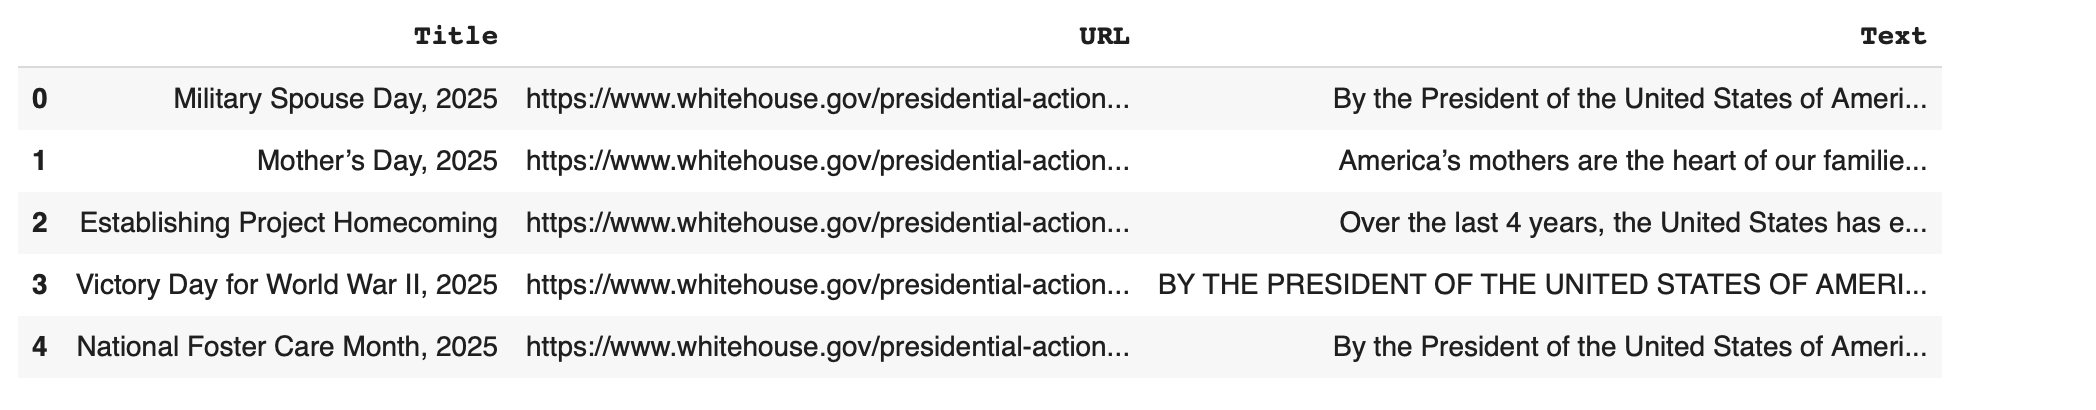

The following is the title and the full text for the first proclamation, Military Spouse Day that you can see above as the first row of the dataframe.

#### Military Spouse Day, 2025

By the President of the United States of America A Proclamation Military spouses are the heart and soul of our Armed Forces.\xa0 Their unwavering devotion and profound influence enrich our fighting forces and the communities in which they serve.\xa0 On Military Spouse Day, we proudly honor the wives and husbands who embrace this noble calling. Every day, military spouses share their loved ones with a demanding, no-fail mission.\xa0 Yet their own mission is no less daunting — frequent relocations to destinations not of their choosing; heart-wrenching separations; parenting, often alone; and career continuity within a nomadic and uncertain life.\xa0 Their ongoing sacrifices are intrinsically linked to family morale, readiness, and retention.\xa0 We cannot maintain the world’s most lethal fighting force without the love, selflessness, and support of the military spouses who navigate the unique and challenging demands in life. Employment is a critical challenge.\xa0 Military spouses face a 21 percent unemployment rate — one of the highest demographics in the country — and a 25 percent wage gap compared to their civilian counterparts.\xa0 Frequent relocations hinder job placements, career advancements, and tenures, regardless of their education and experience.\xa0 During my first Administration, we made significant strides to improve military spouse employment by enhancing job opportunities within the Federal Government, expanding licensure portability, and increasing remote and flexible job options that provide continuity and financial stability for military spouses.\xa0 Earlier this year, I issued a categorical exemption for military spouse employees following the return-to-office directive for Federal civilian employees, and we pledge to pursue additional innovative solutions to help military spouses thrive. It takes uncommon devotion and steadfast love to stand alongside those who wear our Nation’s uniform.\xa0 Yet, generation after generation, military spouses stand in spite of the uncertainty, global threats, increasing demands, long hours, and the deployments that last months or even years.\xa0 They stand –with resilience and resolve — not in the shadow of their loved ones in uniforms, but side by side as an invaluable mission partner and a force multiplier integral to our national defense.\xa0 The First Lady and I are in admiration of these volunteer patriots, heroes, and warriors.\xa0 Military spouses have our unwavering support, our prayers, and the respect of a grateful Nation. NOW, THEREFORE, I, DONALD J. TRUMP, President of the United States of America, by virtue of the authority vested in me by the Constitution and the laws of the United States, do hereby proclaim May 9, 2025, as Military Spouse Day.\xa0 I call upon the people of the United States to honor military spouses with appropriate ceremonies and activities. IN WITNESS WHEREOF, I have hereunto set my hand this ninth day of May, in the year of our Lord two\xa0thousand\xa0twenty-five, and of the Independence of the United\xa0States of\xa0America the two\xa0hundred and forty-ninth. DONALD J. TRUMP

### Format the Dataframe

In [15]:
#This loader takes a df and changes to document specification
loader = DataFrameLoader(result, page_content_column = 'Text')
docs = loader.load()

In [16]:
#here should show the first proclamation being Military Spouse Day and all associated text
docs[0]

Document(metadata={'Title': 'Peace Officers Memorial Day and Police Week, 2025', 'URL': 'https://www.whitehouse.gov/presidential-actions/2025/05/peace-officers-memorial-day-and-police-week-2025/'}, page_content='By the President of the United States of AmericaA Proclamation\n\nOn Peace Officers Memorial Day and during Police Week, we honor our brave officers who serve on the front lines to protect our families, safeguard our communities, and shoulder a burden of responsibility that most Americans cannot fathom.\xa0 This week and always, we honor the courageous men and women serving in law enforcement and memorialize those who sacrificed their lives defending the thin blue line.A nation in chaos ceases to be a citadel of liberty.\xa0 Tragically, the previous administration allowed lawlessness to permeate our country, making it harder for our law enforcement officers to do their jobs.\xa0 Their reckless, soft-on-crime policies emboldened criminals and thugs; wreaked havoc on the sanctity

### Homework Part 2 RAG pipeline

Create a RAG Q&A pipline with the following specifications to create a prompt chain through LangChain. Use the following

*   Gemini's embedding model, **embedding-001**
*   Chroma Vector Database
*   Gemini 2.0 Flash, **gemini-2.0-flash**
*   **temperature=0.75** and  **top_p=0.80** for model parameters
*   Create two Langchain pipeline chains
  *   `rag_chain` - use invoke method to prompt grounded with the Presidential Proclomation documents
  *   `llm_chain` - use invoke method to prompt the base model without context of the documents (not used until question 6)

The following questions should be answered using your pipeline chains like so:

      rag_chain.invoke("Who is the president?")


In [17]:
%pip install -U -q "google-genai>=1.0.0"
%pip install -q chromadb

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [21]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

In [18]:
from google import genai

client = genai.Client(api_key=os.environ['GOOGLE_API_KEY'])

for m in client.models.list():
  if 'embedContent' in m.supported_actions:
    print(m.name)

In [28]:
vectorstore_disk = Chroma(
                        persist_directory="./chroma_db",       # Directory of db
                        embedding_function=gemini_embeddings   # Embedding model
                   )
# Get the Retriever interface for the store to use later.
# When an unstructured query is given to a retriever it will return documents.
# Read more about retrievers in the following link.
# https://python.langchain.com/docs/modules/data_connection/retrievers/

retriever = vectorstore_disk.as_retriever(search_kwargs={"k": 1})

# Check if the retriever is working by trying to fetch the relevant docs related
# to the word 'MMLU' (Massive Multitask Language Understanding). If the length is greater than zero, it means that
# the retriever is functioning well.
print(len(retriever.get_relevant_documents("MMLU")))


/var/folders/m1/_mgj3jf97z5g22msy9qffsbh0000gn/T/ipykernel_10616/2980861368.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore_disk = Chroma(
/var/folders/m1/_mgj3jf97z5g22msy9qffsbh0000gn/T/ipykernel_10616/2980861368.py:18: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  print(len(retriever.get_relevant_documents("MMLU")))


1


In [27]:
gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# Save to disk
vectorstore = Chroma.from_documents(
                     documents=docs,                 # Data
                     embedding=gemini_embeddings,    # Embedding model
                     persist_directory="./chroma_db" # Directory to save data
                     )

from langchain_google_genai import ChatGoogleGenerativeAI

# To configure model parameters use the `generation_config` parameter.
# eg. generation_config = {"temperature": 0.7, "topP": 0.8, "topK": 40}
# If you only want to set a custom temperature for the model use the
# "temperature" parameter directly.

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    model_kwargs={
        "generation_config": {
            "temperature": 0.75,
            "top_p": 0.8
        }
    }
)



In [29]:
llm_prompt_template = """You are an assistant for question-answering tasks.
Use the following context to answer the question.
If you don't know the answer, just say that you don't know.
Use five sentences maximum and keep the answer concise.\n
Question: {question} \nContext: {context} \nAnswer:"""

llm_prompt = PromptTemplate.from_template(llm_prompt_template)

print(llm_prompt)


input_variables=['context', 'question'] input_types={} partial_variables={} template="You are an assistant for question-answering tasks.\nUse the following context to answer the question.\nIf you don't know the answer, just say that you don't know.\nUse five sentences maximum and keep the answer concise.\n\nQuestion: {question} \nContext: {context} \nAnswer:"


In [30]:
#Code for rag_chain RAG pipeline

# 格式化检索文档
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# 构建 RAG 链
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | llm_prompt
    | llm
    | StrOutputParser()
)



In [31]:
rag_chain.invoke("Who is the president?")

"The president is Donald J. Trump. He issued a proclamation for Mother's Day. He acknowledges the importance of mothers. He also mentions his administration's commitment to empowering American mothers and families. He states his intention to protect parents' rights."

In [38]:
llm_prompt_2 = PromptTemplate.from_template("Question: {question}")
llm_chain = (
    RunnablePassthrough()
    | llm_prompt_2
    | llm
    | StrOutputParser()
)
llm_chain.invoke("Who is the president?")

'The current president of the United States is **Joe Biden**.'

### Homework Part 3 Questions

Answer the first 5 with `rag_chain`
1.  Which month is national mental health month?
2.  What is the name of the newly created national monument?
      * Can you verify this is correct (this part can be answered without using rag_chain)?
3. Who does the Education and Sharing Day commemorate?
4. What mountain will be renamed and what day was it proclaimed?
5. Before changing the mountains name what was it called?
    * Is this a good answer?

Create a **second** prompt pipeline called `llm_chain` that does not use the context of the Presidential Proclamations but simply calls the model directly. Answer the remaining questions using both chains.

6. What is Mount McKinley's original name? (2 responses)
7. When did Pope Francis die? (2 responses)
8. Why are the responses different between chains in question 6 & 7?



In [40]:
questions = [
    "Which month is national mental health month?",
    "What is the name of the newly created national monument?",
    "Who does the Education and Sharing Day commemorate?",
    "What mountain will be renamed and what day was it proclaimed?",
    "Before changing the mountain's name what was it called?"
]

for i, q in enumerate(questions, 1):
    print(f"\n❓ Q{i}: {q}")
    result = rag_chain.invoke(q)
    print(f"💡 Answer: {result}")




❓ Q1: Which month is national mental health month?
💡 Answer: National Mental Health Awareness Month is in May. This is according to the proclamation by President Donald J. Trump. He proclaimed May 2025 as National Mental Health Awareness Month. He called upon all Americans to support citizens suffering from mental illnesses. He also wants to raise awareness of mental health conditions.

❓ Q2: What is the name of the newly created national monument?
💡 Answer: The newly created national monument is not explicitly mentioned in this document. However, the document refers to the Pacific Remote Islands Marine National Monument (PRIMNM), which was established in 2009 and expanded in 2014. The proclamation modifies the management of the PRIMNM. It focuses on commercial fishing regulations within the monument. It aims to unleash American commercial fishing in the Pacific.

❓ Q3: Who does the Education and Sharing Day commemorate?
💡 Answer: Education and Sharing Day commemorates the life, legac

In [45]:
questions_2 = [
"6. What is Mount McKinley's original name? ",
"7. When did Pope Francis die?"
]

for i, q in enumerate(questions_2, 1):
    print(f"\n❓ Q {q}")
    result = llm_chain.invoke(q)
    print(f"💡 LLM_Answer: {result}")


for i, q in enumerate(questions_2, 1):
    print(f"\n❓ Q {q}")
    result = rag_chain.invoke(q)
    print(f"💡 RAG_Answer: {result}")




❓ Q 6. What is Mount McKinley's original name? 
💡 LLM_Answer: Mount McKinley's original name is **Denali**.

❓ Q 7. When did Pope Francis die?
💡 LLM_Answer: Pope Francis is still alive as of today, October 26, 2023.

❓ Q 6. What is Mount McKinley's original name? 
💡 RAG_Answer: According to the proclamation, Mount McKinley's rightful name was restored. This implies that Mount McKinley was not its original name. The proclamation suggests the President took action to correct the name. It honored American greatness by returning the mountain to its rightful name. The text does not specify what the original name was.

❓ Q 7. When did Pope Francis die?
💡 RAG_Answer: The document indicates that Pope Francis's death was recognized by the President of the United States with a proclamation. The proclamation orders flags to be flown at half-staff until sunset on the day of interment. The document was signed on April 21, 2025. Therefore, Pope Francis died sometime before April 21, 2025. The exact